# Chapter 8. DQN

Ch 7에서 Q러닝과 신경망을 결합하는 방법을 배웠습니다.

Ch 8 요약: Deep Q Network(DQN) 또한 Q러닝 + 신경망 방법, 2013년~

- DQN은 '경험 재생 + 목표 신경망' 기술이 추가됨
- DQN의 확장 기법인 Double DQN, 우선순위 경험 재생, Dueling DQN 소개
- 실습은 OpenAI Gym 라이브러리 <카트폴> 예제 활용

-------------------------------------

앞 장에서 Q러닝이 신경망으로 발전할 수 밖에 없는 이유가 설명됨</br>
기존 Q러닝은 Q-value를 테이블 형식으로 저장하여 학습 → "state space와 action space가 커지면 Q-value를 저장하기 위해 많은 memory와 긴 exploration time이 필요하게되는데 이를 딥러닝이 해결"

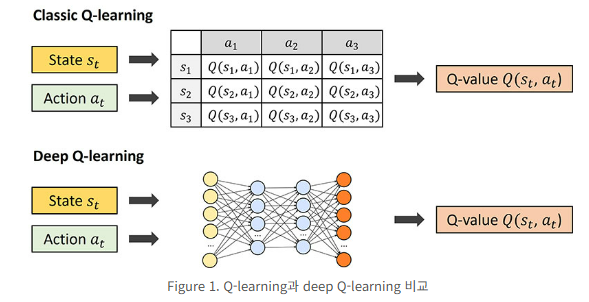

딥러닝은 Q값을 근사시켜서 모든 state-action에 대한 값을 일반화시킨다...(개인적인 표현)

하지만 이러한 Deep Q-learning에도 문제점(학습의 불안정성이나 알고리즘이 수렴하지 않는 경우)이 존재하는데 이것에 대한 해결책인 Deep Q-Network를 이 번 장에서 배운다!!!

-----------------------------------

## 8.1 OpenAI Gym

다양한 강화학습 환경 제공

### 8.1.1 OpenAI Gym 기초 지식

<카트폴>: 좌우로 이동하여 중심잡기

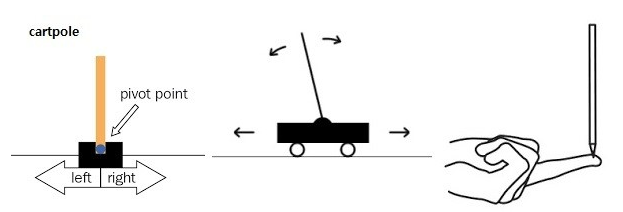

https://mblogthumb-phinf.pstatic.net/MjAxOTA1MDFfMjgw/MDAxNTU2NjgwNTY4MTAw.Z9MlF9jftyK4Bz_tAuJTWDSoapjEjxjm3OwHsPDJW0Ug.3lGamu-GcW_r7t5il4LKboUWWSdD71mmmPA89erbQA0g.GIF.msnayana/cartpole1.gif?type=w800

In [3]:
import gym

env = gym.make('CartPole-v1', render_mode = 'human')

In [4]:
# 초기 상태
state =env.reset()[0]
print('상태', state)

# 행동 공간의 크기(취할 수 있는 행동의 개수)
action_space = env.action_space
print('행동의 차원 수', action_space)

상태 [ 0.04848948 -0.01938602 -0.03371508 -0.0300428 ]
행동의 차원 수 Discrete(2)


※ 변수 설명</br>
상태: [카트의 위치, 카트의 속도, 막대의 각도, 막대의 각속도(회전속도)]</br>
행동의 차원 수: 출력 결과로부터 행동의 후보가 두 가지(0: 카트의 왼쪽, 1: 오른쪽)

In [5]:
# 카트의 왼쪽으로 행동
action = 0
# 행동을 취하는 명령
next_state, reward, terminated, truncated, info = env.step(action)
print(next_state)
print(reward)
print(terminated)
print(truncated)
print(info)

[ 0.04810176 -0.21400866 -0.03431594  0.2518149 ]
1.0
False
False
{}


※ 행동(action=0)을 취하고 다섯 가지 정보를 얻음

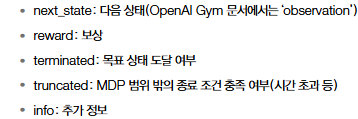

- reward: float, 스칼라값, <카트 폴> 균형이 유지되는 동안에는 보상이 항상 1</br>
- terminated나 truncated는 아래의 상황에서 True를 반환

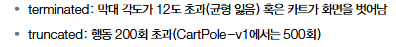

- info: 디버깅에 유용한 정보(환경 모델 등)

--------------------------------

### 8.1.2 랜덤 에이전트

무작위로 행동하는 에이전트를 1회분의 에피소드로 구동하는 코드

In [6]:
import numpy as np
import gym


env = gym.make('CartPole-v1', render_mode='human')
state = env.reset()[0]
done = False

count = 0
# while not done:  # 에피소드가 끝날 때까지 반복
while count < 200:  # 대략 200번 에피소드 반복
    env.render()  # 진행 과정 시각화
    action = np.random.choice([0, 1])  # 행동 선택(무작위)
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated | truncated      # 둘 중 하나만 True면 에피소드 종료
    count += 1
env.close()

c:\Users\teo75\anaconda3\lib\site-packages\gym\envs\classic_control\cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


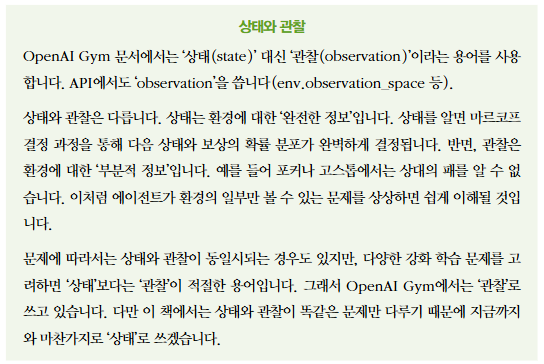

상태와 관찰의 차이: 에이전트가 환경의 전체 정보를 얻느냐, 일부 정보를 얻느냐...

------------------

## 8.2 DQN의 핵심 기술

6장에서 배운 Q러닝은 추정치를 사용하여 추정치를 갱신(부트스트래핑)</br>
문제는 정확하지 않은 추정치를 사용하여 현재의 추정치를 갱신하므로 불안정해지기 쉬움</br>
여기에 신경망처럼 표현력이 높은 함수 근사화 기법이 더해지면 결과는 더욱 불안정해짐 → 과대적합(부록 3 확인)

Q러닝이 불안정해지기 쉬운데 신경망까지 더해지면 더 불안정해진다는 뜻

DQN도 Q러닝과 신경망을 결합한 기법인데</br>
Q러닝의 신경망 학습을 안정화하기 위해 기본적으로 "경험 재생"과 "목표 신경망" 기술 사용</br>
→ 이로인해 처음으로 비디오 게임과 같은 복잡한 문제를 풀어내는데 성공

### 8.2.1 경험 재생

Q러닝에 신경망을 아무 처리없이 적용하기 어려움</br>
그 이유를 'Q러닝'과 '지도학습'의 차이에서 찾을 수 있다!!!

- 지도학습

훈련용 데이터셋이서 일부 데이터를 무작위로 추출(데이터 편향을 막기 위해)하여 미니배치를 만든 후</br>
그 데이터를 이용해 신경망을 학습시켜 매개변수를 갱신</br>

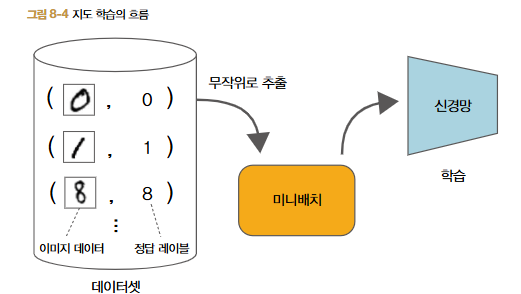

- Q러닝

Q러닝은 에이전트가 환경 속에서 어떤 행동을 취할 때마다 경험데이터를 생성

Sample correlation</br>
경험 데이터는 시간의 흐름에 따라 얻어지며, 시간 간격이 가까운 경험 데이터 사이에는 강한 상관관계가 있음</br>
강한 상관관계가 있다는 뜻은 편향된 데이터를 사용하여 학습한다는 의미

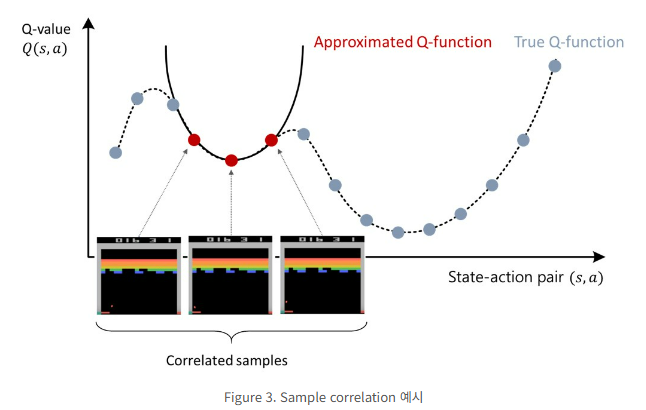

==> 이러한 지도학습과 Q러닝의 차이를 메우는 기법이 경험 재생(Experience replay)임

경험 재생: 경험 데이터를 '버퍼'에 저장하고 Q함수를 갱신할 때 이 버퍼에서 무작위로 꺼내 사용

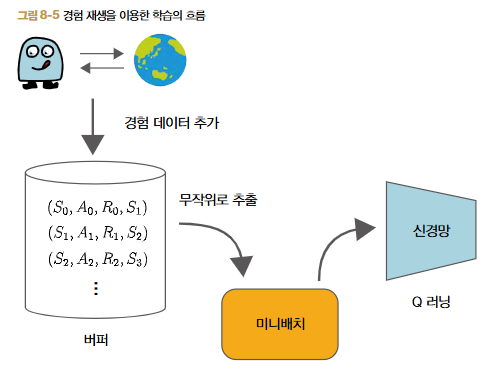

경험 데이터 사이의 상관관계를 약화시커 편향이 적은 데이터 얻을 수 있고 경험 데이터를 반복해서 사용할 수 있기 때문에 데이터 효율도 높아짐

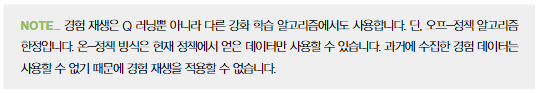

off-policy는 on-policy와 달리 정책 업데이트에 어떤 데이터를 써도 상관이 없음. 즉, 가장 업데이트된 정책에서 수집된 데이터가 아니라도 정책 업데이트에 사용</br>
on-policy는 정책 업데이트에 실제로 행동을 하고 있는 가장 최신 버전의 policy로 수집된 데이터만 사용하는 방식. Data Efficiency가 떨어지지만 구현이 쉽고 여러 종류의 정책에 적용 가능하다는 장점

https://ai-com.tistory.com/entry/RL-%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5-%EC%9D%B4%EB%A1%A0-On-policy-Off-policy

### 8.2.2 경험 재생 구현

경험 재생 버퍼 크기가 정해져 있으므로</br>
데이터 크기가 버퍼 크기에 도달했을 때는 오래된 데이터부터 삭제</br>
선입선출 방식의 collection deque(파이썬 라이브러리) 사용

In [7]:
from collections import deque
import random
import numpy as np
import gym


class ReplayBuffer:
    # 버퍼 초기화
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)             # 버퍼 사이즈
        self.batch_size = batch_size                        # 배치 사이즈
        
    # 경험 데이터 추가 메서드
    def add(self, state, action, reward, next_state, done): # done 추가 
        data = (state, action, reward, next_state, done)
        self.buffer.append(data)                            # add 실행될 때마다 data를 버퍼에 추가
        
    # 버퍼 크기, 현재 들어있는 데이터 크기 알고 싶을 때
    def __len__(self):
        return len(self.buffer)
    
    # 버퍼에 담긴 데이터에서 미니배치를 생성해주는 메서드
    def get_batch(self):
        # 무작위 데이터 추출
        data = random.sample(self.buffer, self.batch_size)
        # 신경망 처리를 쉽게할 수 있도록 np.ndarray 인스턴스로 변환
        state = np.stack([x[0] for x in data])              # state는 리스트 어레이 형태였기 때문에...
        action = np.array([x[1] for x in data])
        reward = np.array([x[2] for x in data])
        next_state = np.stack([x[3] for x in data])
        done = np.array([x[4] for x in data]).astype(np.int32)
        return state, action, reward, next_state, done

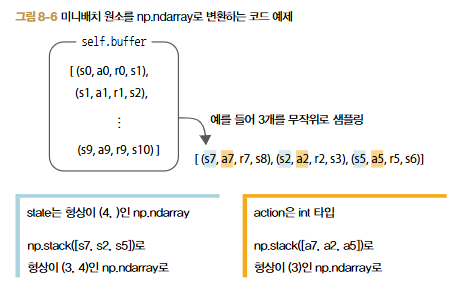

<카트폴> 예시를 사용하기 때문에 형상이 (4,)인듯</br>
상태: [카트의 위치, 카트의 속도, 막대의 각도, 막대의 각속도(회전속도)]

<카트폴>에서 경험 재생 구현 실습

In [8]:
env = gym.make('CartPole-v1', render_mode='human')
replay_buffer = ReplayBuffer(buffer_size=10000, batch_size=32)

for episode in range(10):  # 에피소드 10회 수행
    state = env.reset()[0]                                          # 에피소트 시작시 상태 초기화
    done = False

    while not done:
        action = 0  # 항상 0번째 행동만 수행
        next_state, reward, terminated, truncated, info = env.step(action) # 경험 데이터 획득
        done = terminated | truncated

        replay_buffer.add(state, action, reward, next_state, done)   # 경험 데이터를 버퍼에 추가
        state = next_state

# 경험 데이터 버퍼로부터 미니배치 생성
state, action, reward, next_state, done = replay_buffer.get_batch()
print(state.shape)       # (32, 4)
print(action.shape)      # (32,)
print(reward.shape)      # (32,)
print(next_state.shape)  # (32, 4)
print(done.shape)        # (32,)

(32, 4)
(32,)
(32,)
(32, 4)
(32,)


배치크기 32의 데이터가 추출됨

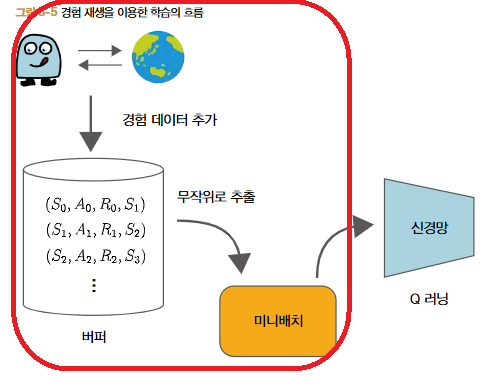

------------------------------------

### 8.2.3 목표 신경망

목표 신경망을 사용한 이유 역시 지도학습과 Q러닝의 차이에서 확인해볼 수 있음

지도학습:</br>
정답 레이블이 바뀌지 않음

Q러닝:</br>
값은 TD 목표값인 가 되도록 Q함수를 갱신</br>
TD 목표 = 지도학습에서의 정답 레이블에 해당</br>
Q함수가 갱신될 때마다 TD 목표 값 바뀜

움직이는 Target value에 의해 신경망의 학습이 불안정해질 수 밖에 없음.</br>
학습 때마다 갱신되는 weight paramter들이 어느 방향으로 가야할지 모르기 때문(개인적인 표현)</br>
→ TD 목표값 고정을 위해 목표 신경망을 사용

목표 신경망에서는...</br>
Q함수를 나타내는 원본 신경망(qnet)과 그와 같은 qnet_target을 준비</br>
qnet은 Q러닝을 갱신하고
qnet_target은 주기적으로 qnet의 가중치와 동기화, 그 외에는 가중치 매개변수를 고정

qnet_target으로 TD 목표 값을 계산하면 TD 목표가 바뀌는 것을 억제</br>
정답 레이블 TD 목표가 바뀌지 않으므로 신경망 학습의 안정화 기대

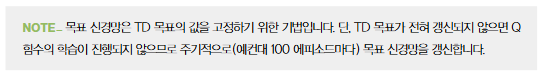

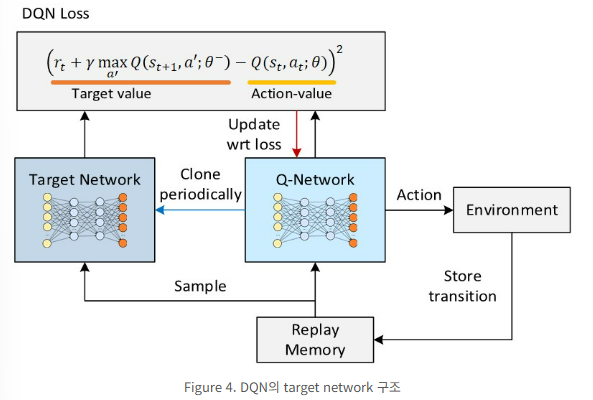

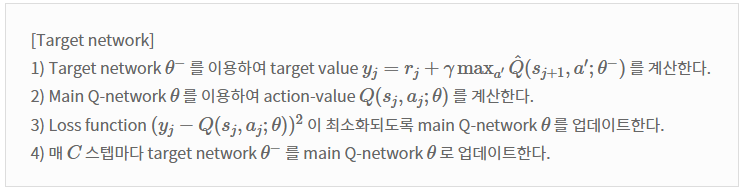

여기서 잠깐... 목표 신경망 구현에 앞서 정리...

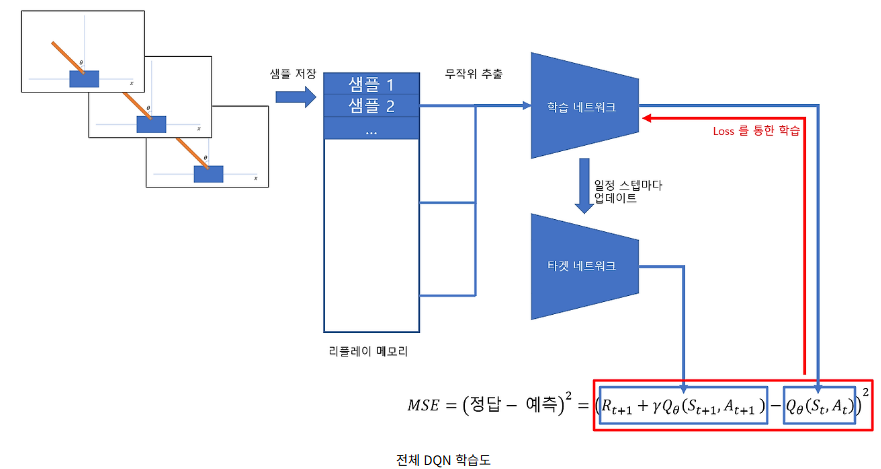

### 8.2.4 목표 신경망 구현

In [9]:
import copy
from collections import deque
import random
import matplotlib.pyplot as plt
import numpy as np
import gym
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L


class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        self.buffer.append(data)

    def __len__(self):
        return len(self.buffer)

    def get_batch(self):
        data = random.sample(self.buffer, self.batch_size)

        state = np.stack([x[0] for x in data])
        action = np.array([x[1] for x in data])
        reward = np.array([x[2] for x in data])
        next_state = np.stack([x[3] for x in data])
        done = np.array([x[4] for x in data]).astype(np.int32)
        return state, action, reward, next_state, done


class QNet(Model):  # 신경망 클래스
    def __init__(self, action_size):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(128)
        self.l3 = L.Linear(action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x


class DQNAgent:  # 에이전트 클래스
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0005
        self.epsilon = 0.1
        self.buffer_size = 10000  # 경험 재생 버퍼 크기
        self.batch_size = 32      # 미니배치 크기
        self.action_size = 2      # 선택을 할 수 있는 Action 개수

        self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)
        # qnet
        self.qnet = QNet(self.action_size)         # 원본 신경망
        # qnet_target
        self.qnet_target = QNet(self.action_size)  # 목표 신경망
        self.optimizer = optimizers.Adam(self.lr)
        # 가중치 매개변수 갱신은 qnet에서만 이뤄짐
        self.optimizer.setup(self.qnet)            # 옵티마이저에 qnet 등록

    
    def get_action(self, state):
        if np.random.rand() < self.epsilon:        # 에이전트가 무작위로 행동 선택할 확률 = epsilon
            return np.random.choice(self.action_size)   # 무작위로 행동 선택
        else:                                           # 현재의 정책에 따라 행동 선택
            state = state[np.newaxis, :]                # 배치 처리용 차원 추가(배치 형태로 처리하기 위해) 원래 state가 (n,) 형태면 (1,n) 형태로
            qs = self.qnet(state)                       # state를 qnet에 넣어 Q값 예측
            return qs.data.argmax()                     # Q값 중 가장 큰 값을 가지는 행동을 선택하여 반환, 최적의 행동 선택
    
    # 두 신경망 동기화, 깊은 복사
    def sync_qnet(self):  # 두 신경망 동기화
        self.qnet_target = copy.deepcopy(self.qnet)
    
    # 가중치 매개변수 갱신 메서드
    def update(self, state, action, reward, next_state, done):
        # 경험 재생 버퍼에 경험 데이터 추가
        self.replay_buffer.add(state, action, reward, next_state, done)
        if len(self.replay_buffer) < self.batch_size:
            return  # 데이터가 미니배치 크기만큼 쌓이지 않았다면 여기서 끝

        # 미니배치 크기 이상이 쌓이면 미니배치 생성
        state, action, reward, next_state, done = self.replay_buffer.get_batch()
        # 32개 분량의 데이터를 qnet에 제공
        qs = self.qnet(state)   # state 32x4
        # q 함수 출력은 action이 2개(왼쪽 0, 오른쪽 1)인 32x2 크기
        q = qs[np.arange(self.batch_size), action] #32x2         # 주어진 상태에서 특정 행동을 취했을 때의 예상되는 보상

        # qnet_target을 사용하여 다음 상태의 q함수값 계산
        next_qs = self.qnet_target(next_state)
        # 다음 상태의 Q함수는 배치 데이터의 최대값 선택
        next_q = next_qs.max(axis=1)
        next_q.unchain()
        # TD 목표값 계산
        target = reward + (1 - done) * self.gamma * next_q      # 실제 관찰된 보상을 기반으로 계산된 값으로 Q값과 다음 상태의 Q값을 고려하여 계산

        loss = F.mean_squared_error(q, target)

        self.qnet.cleargrads()                      # 역전파를 수행하기 전에 그래디언트를 초기화하여 이전 배치의 그래디언트가 현재 배치의 그래디언트 계산에 영향을 미치지 않도록
        loss.backward()                             # 역전파를 수행하여 각 가중치에 대한 그래디언트를 계산, 가중치를 업데이트 하는데 필요한 방향과 크기 결정
        self.optimizer.update()                     # 최적화 알고리즘을 사용하여 신경망의 가중치를 업데이트

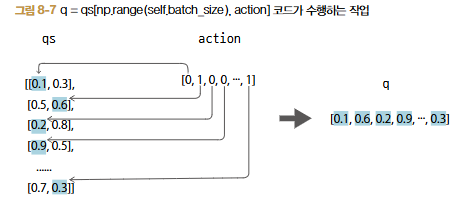

-----------------------------------------------

### 8.2.5 DQN 실행

episode :0, total reward : 10.0
episode :10, total reward : 16.0
episode :20, total reward : 21.0
episode :30, total reward : 10.0
episode :40, total reward : 10.0
episode :50, total reward : 9.0
episode :60, total reward : 11.0
episode :70, total reward : 10.0
episode :80, total reward : 9.0
episode :90, total reward : 37.0
episode :100, total reward : 36.0
episode :110, total reward : 102.0
episode :120, total reward : 50.0
episode :130, total reward : 119.0
episode :140, total reward : 257.0
episode :150, total reward : 276.0
episode :160, total reward : 183.0
episode :170, total reward : 232.0
episode :180, total reward : 149.0
episode :190, total reward : 106.0
episode :200, total reward : 141.0
episode :210, total reward : 330.0
episode :220, total reward : 207.0
episode :230, total reward : 321.0
episode :240, total reward : 259.0
episode :250, total reward : 215.0
episode :260, total reward : 274.0
episode :270, total reward : 321.0
episode :280, total reward : 238.0
episode :2

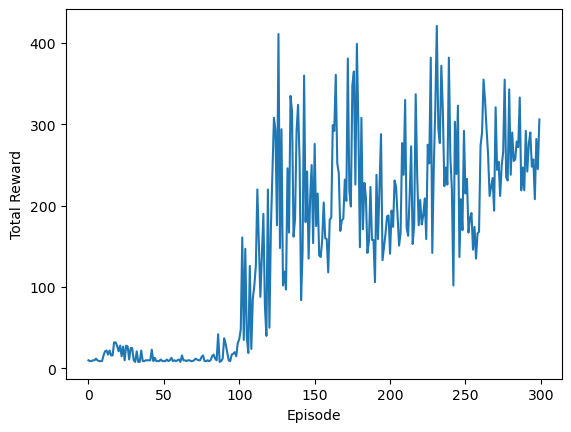

In [10]:
episodes = 300      # 에피소드 수
sync_interval = 20  # 신경망 동기화 주기(20번째 에피소드마다 동기화)
env = gym.make('CartPole-v1', render_mode='rgb_array')
agent = DQNAgent()
reward_history = [] # 에피소드별 보상 기록

for episode in range(episodes):
    state = env.reset()[0]
    done = False
    total_reward = 0

    while not done:
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated | truncated

        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    if episode % sync_interval == 0:
        agent.sync_qnet()

    reward_history.append(total_reward)
    # episode 10마다 모니터링
    if episode % 10 == 0:
        print("episode :{}, total reward : {}".format(episode, total_reward))


# [그림 8-8] 「카트 폴」에서 에피소드별 보상 총합의 추이
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(range(len(reward_history)), reward_history)
plt.show()



보상 총합 기록되어있음

여기에 에이전트에게 탐욕 행동을 따르도록 해보면...

In [11]:
# 학습이 끝난 에이전트에 탐욕 행동을 선택하도록 하여 플레이
agent.epsilon = 0  # 탐욕 정책(무작위로 행동할 확률 ε을 0로 설정)
state = env.reset()[0]
done = False
total_reward = 0

while not done:
    action = agent.get_action(state)
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated | truncated
    state = next_state
    total_reward += reward
    env.render()
print('Total Reward:', total_reward)

Total Reward: 180.0


탐욕행동을 통해 xxx 전체 보상을 받으며 균형을 잡음

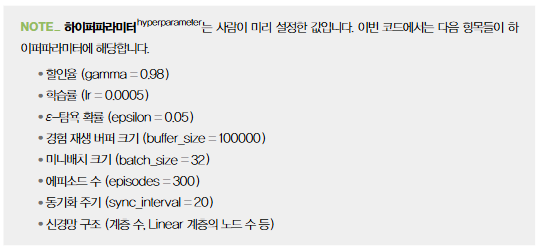